# Wires knobs in the Run3 Optics
---

In this [notebook](https://gitlab.cern.ch/sterbini/lhcmaskdoc/-/blob/master/docs/ipynbs/wires_run3/b1_checks.ipynb), we go through the implementation of the beam-beam long-range wire compensators (denoted BBCW) in the LHC mask together with sanity checks. In order to ease the task for the user, a package is proposed, containing the necessary classes to properly install and tune the wires in the MAD-X file. It can be found on [Github](https://github.com/apoyet/bbcw2mad), do not hesitate to collaborate.

In order to install the package, simply use pip as follow: 
```bash
pip install --user git+https://github.com/apoyet/bbcw2mad.git
```

Or to update the package: 
```bash
pip install --upgrade --user git+https://github.com/apoyet/bbcw2mad.git
```

The package lives by itself, and no error will be raised in case you import only this package. However it is meant to be used with the python wrapper of MAD-X, [cpymad](http://hibtc.github.io/cpymad/index.html).

!!! warning
    In this document, we focus on B2. A lot of checks should be done. For that reason, the checks on B1 are done similarly in another document that can be found [here](https://gitlab.cern.ch/sterbini/lhcmaskdoc/-/blob/master/docs/ipynbs/wires_run3/b1_checks.md).


---
## **Environment preparation** 

Before starting to talk about the mask itself, let us setup the environment. The distribution used in this example is the one available on SWAN, the LCG96 (python 3).

In this document, we will take as an example the LHC Run 3. The goal is therefore two-folded: show the new approach of implementing the wires in the new LHC mask, but also prepare the operation of the next LHC run. 

In [1]:
!which python

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/bin/python


Then the usual needed packages can be imported:

In [2]:
# %% Import few packages
from cpymad.madx import Madx
from madxp import cpymadTool as mt
from collections import OrderedDict
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from IPython.display import display
import time
import os
import warnings
warnings.filterwarnings('always')
from cl2pd import importData
from cl2pd import particle
import gc
import datetime


And finally the modules of the bbcw2mad package. We recommend to import them as follow: 

In [3]:
from bbcw2mad.WireObj import WireObj
from bbcw2mad.KnobObj import KnobObj

The ```WireObj``` module contains the class defining the wire compensator as a pythonic object. On the other hand, the ```KnobObj``` module contains the class used to define the knobs used in operation (eg, tune or chromaticity feedforward). 

## **A collection of working flow functions** 

In the next cell, we import a collection of functions used in the working flow. These functions are exposed in the ```toolbox.py``` file since the user might need to access or modify them in order to adapt them ask to their use case. This file can be found [here](https://gitlab.cern.ch/sterbini/lhcmaskdoc/-/blob/master/docs/ipynbs/wires_run3/toobox.py). 

In [4]:
import toolbox as tb

!!! warning
    In general, cells should not be run more than once as they contain MAD-X code, and running a cell several times can lead to errors. 

In [5]:
start_time = time.time()

---
## **Tests at injection**

We first make tests at injection, computing orbit and tune shifts induced by a single wire. 

### **Parameters Dictionary**

All the parameters we need are defined in the following dictionnary:

*NB: In this dictionnary, we define the transverse position of the wires. The chosen values correspond to the actual operation TCT configuration for a typical foreseen end-of-fill, with $\beta^{*}$ equals to 30 cm.* 

In [6]:
parameter_dict={
    # =============================================================================
    # Beam parameters
    # =============================================================================
    ## LHC beam 1 (clockwise), LHC beam 2 (clockwise), LHC beam 2 (counterclockwise) 
    'par_mylhcbeam': 2, 
    ## beam normalized emittance [m rad]
    'par_beam_norm_emit': 2.5e-6,
    ## [m]
    'par_beam_sigt': 0.075,
    ## [-]           
    'par_beam_sige': 1.1e-4,
    ## [-]                    
    'par_beam_npart': 1.1e11, 
    ## [GeV]            
    'par_beam_energy_tot': 450,
    ## [A]          
    'par_oct_current': 20,
    ## [-]            
    'par_chromaticity': 15,
    ## [MV]          
    'par_vrf_total': 16.,
    ## Tunes with fractional part          
    'par_qx0': 62.275, 'par_qy0': 60.29,
    # =============================================================================
    # Beam-Beam configuration 
    # =============================================================================
    ## install the BB elements [0,1]
    'par_on_bb_switch': 0,
    ## if 1 lumi leveling in ip8 is applied and q/q' match is done with bb off [0,1]
    'par_on_collision': 0, 
    ## bunch separation [ns]               
    'par_b_t_dist': 25.,   
    ## default value for the number of additionnal parasitic encounters inside D1              
    'par_n_inside_D1': 5,                 
    ## number of slices for head-on in IR1 [between 0 and 201]
    'par_nho_IR1': 11, 'par_nho_IR2': 11, 'par_nho_IR5': 11, 'par_nho_IR8': 11, 
    ## flag to install the Crab Cavities [0, 1]
    'par_install_crabcavities': 0,
    # =============================================================================
    # Beam-Beam Wire Compensators 
    # =============================================================================
    ## IR1
    'par_s_w_ir1': 20140.1074,              # s-position [m]
    'par_x_w_ir1': 0,                         # Horizontal transverse position of the wire, wrt to the beam [m]
    'par_y_w_ir1': 0.0091,                    # Vertical transverse position of the wire, wrt to the beam [m]
    'par_I_w_ir1': 0,                       # Wire Current [A]
    ## IR5
    'par_s_w_ir5': 6812.818067,               # s-position [m]
    'par_x_w_ir5': 0.01223,                   # Horizontal transverse position of the wire, wrt to the beam [m]
    'par_y_w_ir5': 0,                         # Vertical transverse position of the wire, wrt to the beam [m]
    'par_I_w_ir5': 0,                       # Wire Current [A]
    # =============================================================================
    # Leveling in IP8   
    # =============================================================================
    # leveled luminosity in IP8 (considered if par_on_collision=1) [Hz/cm2]
    'par_lumi_ip8': 2e32,                 
    # These variables define the number of Head-On collisions in the 4 IPs
    'par_nco_IP1': 2544, 'par_nco_IP2': 2215, 'par_nco_IP5': 2544, 'par_nco_IP8': 2332,
    # =============================================================================
    # Errors and corrections 
    # =============================================================================
    # Select seed for errors
    'par_myseed': 0,
    # Set this flag to correct the errors of D2 in the NLC 
    # (warning: for now only correcting b3 of D2, still in development)
    'par_correct_for_D2': 0,
    # Set this flag to correct the errors of MCBXF in the NLC 
    # (warning: this might be less reproducable in reality, use with care)
    'par_correct_for_MCBX': 0,
    'par_off_all_errors': 0,
    'par_on_errors_LHC': 0,
    'par_on_errors_MBH': 0,
    'par_on_errors_Q5': 0,
    'par_on_errors_Q4': 0,
    'par_on_errors_D2': 0,
    'par_on_errors_D1': 0,
    'par_on_errors_IT': 0,
    'par_on_errors_MCBRD': 0,
    'par_on_errors_MCBXF': 0,
    # =============================================================================
    # Additional parameters
    # =============================================================================
    # parameter for having verbose output [0,1]
    'par_verbose': 1,
    # definition of the slicefactor used in the makethin
    'par_slicefactor': 4,
    # number of optics to use
    'par_optics_number':1,
    # Specify machine version
    'ver_lhc_run' : 3, 'ver_hllhc_optics' : 0,
}

### **Start the MAD-X instance**

Then MAD-X is launched using cpymad. The standard output and log are redirected to files. 

We make the links to the different needed folders.

In [7]:
tb.make_links()
command_log_file='log.madx'
stdout_file='stdout.madx'
with open(stdout_file, 'w') as myFile:
    mad = Madx(stdout=myFile,command_log=command_log_file)

working_folder='./'
os.chdir(working_folder)

### **Definition of the wires**

We now define the wire compensators. They are defined as pythonic objects. To define a wire, one has to create an instance of the ```WireObj``` class. 

In [8]:
sequence_w = f'lhcb{parameter_dict["par_mylhcbeam"]}'
mad_inst_w = mad
# WIRE IR1
s_w_ir1 = parameter_dict['par_s_w_ir1']
x_w_ir1 = parameter_dict['par_x_w_ir1']
y_w_ir1 = parameter_dict['par_y_w_ir1']
I_w_ir1 = parameter_dict['par_I_w_ir1']
# WIRE IR5
s_w_ir5 = parameter_dict['par_s_w_ir5']
x_w_ir5 = parameter_dict['par_x_w_ir5']
y_w_ir5 = parameter_dict['par_y_w_ir5']
I_w_ir5 = parameter_dict['par_I_w_ir5']

# Define the wires 

bbcw_int_r1b2 = WireObj('bbcw_int_r1b2',I_w_ir1,s_w_ir1,x_w_ir1,y_w_ir1,parameter_dict['par_beam_npart'],mad_inst=mad_inst_w,sequence=sequence_w)
bbcw_ext_r1b2 = WireObj('bbcw_ext_r1b2',I_w_ir1,s_w_ir1,x_w_ir1,-y_w_ir1,parameter_dict['par_beam_npart'],mad_inst=mad_inst_w,sequence=sequence_w)

bbcw_int_r5b2 = WireObj('bbcw_int_r5b2',I_w_ir5,s_w_ir5,x_w_ir5,y_w_ir5,parameter_dict['par_beam_npart'],mad_inst=mad_inst_w,sequence=sequence_w)
bbcw_ext_r5b2 = WireObj('bbcw_ext_r5b2',I_w_ir5,s_w_ir5,-x_w_ir5,y_w_ir5,parameter_dict['par_beam_npart'],mad_inst=mad_inst_w,sequence=sequence_w)

# Wires to install in the sequence
wires_seq = [bbcw_int_r1b2, bbcw_ext_r1b2, bbcw_int_r5b2, bbcw_ext_r5b2]

# Wires to be powered (only one)
wires_lst = [bbcw_int_r5b2]

# describe the wire
bbcw_int_r5b2.describe()

{'current': 0,
 'mad_inst': <cpymad.madx.Madx object at 0x7fc91531c828>,
 'name': 'bbcw_int_r5b2',
 'nb': 110000000000.0,
 's_pos': 6812.818067,
 'sequence': 'lhcb2',
 'sigx': 0.0003333333333333333,
 'sigy': 0.0003333333333333333,
 'switch': 0,
 'x_co': 0,
 'x_pos': 0.01223,
 'xma': 0.01223,
 'y_co': 0,
 'y_pos': 0,
 'yma': 0}


### **Build the LHC sequence and load optics**

We start by building the LHC sequence. Then we load the selected optics file. 

In [9]:
workflow_dict = OrderedDict()
workflow_dict['read_parameters_inj'] = tb.read_parameters(mad, parameter_dict)
workflow_dict['make_sequence'] = tb.make_sequence(mad, parameter_dict['par_mylhcbeam'], parameter_dict['par_slicefactor'],wires_lst=wires_seq)
workflow_dict['load_optics_inj'] = tb.load_optics(mad, parameter_dict['par_optics_number'])
workflow_dict['check_optics_inj'] = tb.run_module(mad,'module_00_check_optics.madx')

Let us save the tunes of the bare machine. 

In [10]:
qx_0 = mad.table.summary_bare_optics_b2['q1'][0]
qy_0 = mad.table.summary_bare_optics_b2['q2'][0]

### **Update the position of the wires, and power**

We now update the position of the wires taking into consideration the closed orbit, and we power then. In this case, only one wire in IR5 is powered. While scanning the current, two scans will be performed. One with the ```bborbit``` flag set to ```False```, and one with the flag set to ```True``` in order to check orbit effects.

In [11]:
for wire in wires_lst:
    wire.get_closed_orbit(table_input='twiss_bare_optics_b2')

workflow_dict['turn_on_wires_inj'] = tb.power_wires(wires_lst,table_out='b2_wires')
workflow_df=pd.DataFrame(workflow_dict).transpose()

Tunes should be unchanged as the wire current is set to zero: 

In [12]:
print(f"Delta Qx = {mad.table.summary_b2_wires['q1'][0] - qx_0}")
print(f"Delta Qy = {mad.table.summary_b2_wires['q2'][0] - qy_0}")

Delta Qx = 0.0
Delta Qy = 0.0


We then prepare for the current scan: 

In [13]:
Iw = [0, 10, 50, 100, 150, 200, 250, 300, 350]

# Initial points
# Tunes
qx_0 = mad.table.summary_b2_wires['q1'][0]
qy_0 = mad.table.summary_b2_wires['q2'][0]

twiss_table = mad.table.twiss_b2_wires
# orbit
x_0 = twiss_table.x[np.where(twiss_table.name==wires_lst[0].name+':1')][0]
y_0 = twiss_table.y[np.where(twiss_table.name==wires_lst[0].name+':1')][0]

# beta function at the wires 

betx_w = twiss_table.betx[np.where(twiss_table.name==wires_lst[0].name+':1')][0]
bety_w = twiss_table.bety[np.where(twiss_table.name==wires_lst[0].name+':1')][0]

# Initialize lists
qx_inj = []
qy_inj = []
x_inj = []
y_inj = []

As mentioned, we first scan the wire current with the ```bborbit``` flag set to False (which is the case by default). 

In [14]:
mad.use(sequence='lhcb2')
for iw in Iw: 
    wires_lst[0].update_current(Iw_new=iw)
    mad.twiss(sequence='lhcb2')
    qx_inj.append(mad.table.summ['q1'][0])
    qy_inj.append(mad.table.summ['q2'][0])
    
    gc.collect()

dqx_inj = np.array(qx_inj)-qx_0
dqy_inj = np.array(qy_inj)-qy_0

We then set the ```bborbit``` flag to True and scan again to observe orbit effects. 

In [15]:
mad.input('''
option, bborbit=true;
''')
for iw in Iw: 
    wires_lst[0].update_current(Iw_new=iw)
    twiss_table = mad.twiss(sequence='lhcb2')
    x_inj.append(twiss_table.x[np.where(twiss_table.name==wires_lst[0].name+':1')][0])
    y_inj.append(twiss_table.y[np.where(twiss_table.name==wires_lst[0].name+':1')][0])
    
    gc.collect()

dx_inj = np.array(x_inj)-x_0
dy_inj = np.array(y_inj)-y_0

We can now compare the results with the ones given by the analytical formulas.

In [16]:
Iw_full = np.linspace(0,350,100)
q_shift = tb.tune_shift(I_L=Iw_full, r_w=wires_lst[0].x_pos, betx=betx_w, bety=bety_w, phi_w=0, Brho=particle.setTotalEnergy_GeV(450)['magneticRigidity_Tm'])
dqx_th_inj = q_shift[0]
dqy_th_inj = q_shift[1]

And plot: 

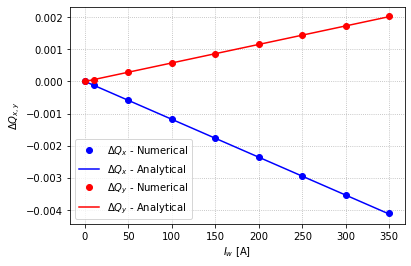

In [17]:
plt.plot(Iw, dqx_inj, 'bo', label='$\\Delta Q_x$ - Numerical')
plt.plot(Iw_full, dqx_th_inj, 'b-', label='$\\Delta Q_x$ - Analytical')
plt.plot(Iw, dqy_inj, 'ro', label='$\\Delta Q_y$ - Numerical')
plt.plot(Iw_full, dqy_th_inj, 'r-', label='$\\Delta Q_y$ - Analytical')

plt.xlabel('$I_w$ [A]')
plt.ylabel('$\\Delta Q_{x,y}$')
plt.legend(loc='best')
plt.grid(ls=':');

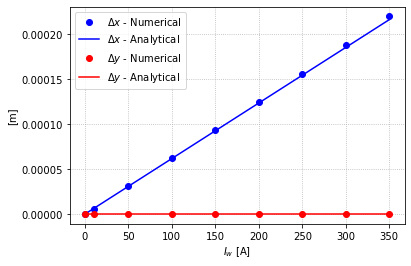

In [18]:
co_shift = tb.orbit_shift(I_L=Iw_full, r_w=wires_lst[0].x_pos, betx=betx_w, bety=bety_w, \
                                   qx=qx_0, qy=qy_0, phi_w=0, Brho=particle.setTotalEnergy_GeV(450)['magneticRigidity_Tm'])

dx_th_inj = co_shift[0]
dy_th_inj = co_shift[1]

# Plot

plt.plot(Iw, dx_inj, 'bo', label='$\\Delta x$ - Numerical')
plt.plot(Iw_full, dx_th_inj, 'b-', label='$\\Delta x$ - Analytical')
plt.plot(Iw, dy_inj, 'ro', label='$\\Delta y$ - Numerical')
plt.plot(Iw_full, dy_th_inj, 'r-', label='$\\Delta y$ - Analytical')

plt.xlabel('$I_w$ [A]')
plt.ylabel('[m]')
plt.legend(loc='best')
plt.grid(ls=':');

Both tune and orbit shift are under control. The small difference between numerical and analytical results can be explained by the beta-beating induced by the wire, that is not taken into consideration in the analytical results. 


Before changing optics, we turn off the wire. 

In [19]:
wires_lst[0].update_current(Iw_new=0)

---
## **Tests at flat-top energy (open loop)**

We now make the same tests as at injection, but at flat-top energy, computing orbit and tune shifts induced by a single wire. In order to avoid orbit effects from the bb elements, beams are separated, and long-ranges are not installed 

### **Parameters Dictionary**

We update the dictionary containing the parameters: 

In [20]:
parameter_dict.update({
    'par_beam_energy_tot': 7000,
    'par_oct_current': 350,
    'par_qx0': 62.31, 'par_qy0': 60.32,
    'par_optics_number':27,
})

### **Reload the new optics**

In [21]:
workflow_dict['read_parameters_FT'] = tb.read_parameters(mad, parameter_dict)
workflow_dict['load_optics_FT'] = tb.load_optics(mad, parameter_dict['par_optics_number'])
workflow_dict['check_optics_FT'] = tb.run_module(mad,'module_00_check_optics.madx')

In [22]:
qx_0 = mad.table.summary_bare_optics_b2['q1'][0]
qy_0 = mad.table.summary_bare_optics_b2['q2'][0]

### **Update the position of the wires, and power**

We now update the position of the wires taking into consideration the closed orbit, and we power then. In this case, only one wire in IR5 is powered. While scanning the current, two scans will be performed. One with the ```bborbit``` flag set to ```False```, and one with the flag set to ```True``` in order to check orbit effects.

In [23]:
for wire in wires_lst:
    wire.get_closed_orbit(table_input='twiss_bare_optics_b2')

workflow_dict['turn_on_wires_FT'] = tb.power_wires(wires_lst,table_out='b2_wires')
workflow_df=pd.DataFrame(workflow_dict).transpose()

Tunes should be unchanged as the wire current is set to zero: 

In [24]:
print(f"Delta Qx = {mad.table.summary_b2_wires['q1'][0] - qx_0}")
print(f"Delta Qy = {mad.table.summary_b2_wires['q2'][0] - qy_0}")

Delta Qx = 0.0
Delta Qy = 0.0


In [25]:
# Current scan 

Iw = [0, 10, 50, 100, 150, 200, 250, 300, 350]

# Initial points
# Tunes
qx_0 = mad.table.summary_b2_wires['q1'][0]
qy_0 = mad.table.summary_b2_wires['q2'][0]

twiss_table = mad.table.twiss_b2_wires
# orbit
x_0 = twiss_table.x[np.where(twiss_table.name==wires_lst[0].name+':1')][0]
y_0 = twiss_table.y[np.where(twiss_table.name==wires_lst[0].name+':1')][0]

# beta function at the wires 

betx_w = twiss_table.betx[np.where(twiss_table.name==wires_lst[0].name+':1')][0]
bety_w = twiss_table.bety[np.where(twiss_table.name==wires_lst[0].name+':1')][0]

# Initialize lists
qx_FT = []
qy_FT = []
x_FT = []
y_FT = []

In [26]:
# scan for tunes (bborbit false)

mad.use(sequence='lhcb2')
for iw in Iw: 
    wires_lst[0].update_current(Iw_new=iw)
    mad.twiss(sequence='lhcb2')
    qx_FT.append(mad.table.summ['q1'][0])
    qy_FT.append(mad.table.summ['q2'][0])
    gc.collect()

dqx_FT = np.array(qx_FT)-qx_0
dqy_FT = np.array(qy_FT)-qy_0

In [27]:
# scan for orbit (bborbit true)
mad.input('option, bborbit=true;')
for iw in Iw: 
    wires_lst[0].update_current(Iw_new=iw)
    twiss_table = mad.twiss(sequence='lhcb2')
    x_FT.append(twiss_table.x[np.where(twiss_table.name==wires_lst[0].name+':1')][0])
    y_FT.append(twiss_table.y[np.where(twiss_table.name==wires_lst[0].name+':1')][0])
    gc.collect()

dx_FT = np.array(x_FT)-x_0
dy_FT = np.array(y_FT)-y_0

In [28]:
# Theretical formulas

Iw_full = np.linspace(0,350,100)
q_shift = tb.tune_shift(I_L=Iw_full, r_w=wires_lst[0].x_pos, betx=betx_w, bety=bety_w, phi_w=0, Brho=particle.setTotalEnergy_GeV(7000)['magneticRigidity_Tm'])
dqx_th_FT = q_shift[0]
dqy_th_FT = q_shift[1]

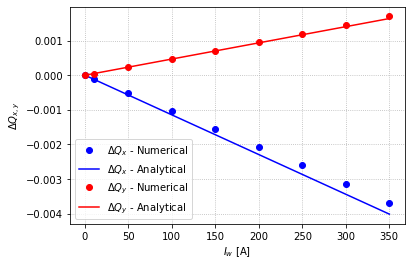

In [29]:
# Plot

plt.plot(Iw, dqx_FT, 'bo', label='$\\Delta Q_x$ - Numerical')
plt.plot(Iw_full, dqx_th_FT, 'b-', label='$\\Delta Q_x$ - Analytical')
plt.plot(Iw, dqy_FT, 'ro', label='$\\Delta Q_y$ - Numerical')
plt.plot(Iw_full, dqy_th_FT, 'r-', label='$\\Delta Q_y$ - Analytical')

plt.xlabel('$I_w$ [A]')
plt.ylabel('$\\Delta Q_{x,y}$')
plt.legend(loc='best')
plt.grid(ls=':');

In [30]:
co_shift = tb.orbit_shift(I_L=Iw_full, r_w=wires_lst[0].x_pos, betx=betx_w, bety=bety_w, \
                                   qx=qx_0, qy=qy_0, phi_w=0, Brho=particle.setTotalEnergy_GeV(7000)['magneticRigidity_Tm'])

dx_th_FT = co_shift[0]
dy_th_FT = co_shift[1]

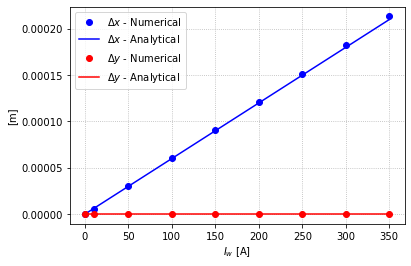

In [31]:
# Plot

plt.plot(Iw, dx_FT, 'bo', label='$\\Delta x$ - Numerical')
plt.plot(Iw_full, dx_th_FT, 'b-', label='$\\Delta x$ - Analytical')
plt.plot(Iw, dy_FT, 'ro', label='$\\Delta y$ - Numerical')
plt.plot(Iw_full, dy_th_FT, 'r-', label='$\\Delta y$ - Analytical')

plt.xlabel('$I_w$ [A]')
plt.ylabel('[m]')
plt.legend(loc='best')
plt.grid(ls=':');

Just like in the injection energy case, the tune and orbit shifts are perfectly under control. Let us turn off the wire before the next tests.

In [32]:
wires_lst[0].update_current(Iw_new=0)

---
## **Tests at flat-top energy and tune feed-forward**

As seen previsouly, the tune shift induced by a single wire is already of the order of 1 to 3$\cdot$10$^{-4}$. With the 2-jaw powering of the wire, the quadrupolar term is doubled while the orbit shift cancels out. During the operation of the LHC in Run 3, the tune shift induced by the wires is compensated using the Q4 quadrupoles in IR1 and IR5. Knobs have been implemented and are tested in the next section.

The energy is set to 7 TeV.

!!! important
    In the following, we are assuming the positionning of the wires corresponding to the operational opening of the wire collimators (8.5 $\sigma_{coll})$). In operation, the wires are foreseen to be powered at the end of the $\beta$-levelling. The computed beam-wire distances therefore correspond to this machine configuration ($\beta^{*}$ = 30cm). In case of change of optics, the beam-wires distances (in m) are not recomputed since the pupose of this document is simply to check the effect of the wires. 

!!! warning
    In this section, we exclude the effect of the beam-beam elements installed in the machine since we are only interested into the effect of the wires themselves. 
    
Assuming a 2-jaws powering configuration, the tune feed-forward using the Q4 on both side of the IP is defined as followed, in IR1:

$$
k_{Q4}^{L1} = -3.386 \cdot 10^{-3}- 6.216 \cdot 10^{-6} \frac{I_{w1}/(350~{\rm A})}{(y_{w,r1}/(9.105~{\rm mm}))^2} \\
k_{Q4}^{R1} = 3.386 \cdot 10^{-3} - 2.248 \cdot 10^{-5} \frac{I_{w1}/(350~{\rm A})}{(y_{w,r1}/(9.105~{\rm mm}))^2}
$$

and in IR5:

$$
k_{Q4}^{L5} = -3.386 \cdot 10^{-3} + 3.136 \cdot 10^{-6} \frac{I_{w5}/(350~{\rm A})}{(x_{w,r5}/(12.237~{\rm mm}))^2} \\
k_{Q4}^{R5} = 3.386 \cdot 10^{-3} + 1.223 \cdot 10^{-5} \frac{I_{w5}/(350~{\rm A})}{(x_{w,r5}/(12.237~{\rm mm}))^2}
$$.


The FF has been designed for the end-of-fill configuration but - as we will see later - is tele-index independant. With $\beta^{*}$ = 30cm, the initial values of the Q4 stregnths are:

$$
k_{q4,0}^{l1} =  -0.00338572138643  \\
k_{q4,0}^{r1} =  0.00338572138643 \\
k_{q4,0}^{l5} =  -0.00338572138643  \\
k_{q4,0}^{r5} =  0.00338572138643 
$$

The proposed Q4 strength excursion therefore represents a variation of less than 1% compared to their nominal values. 

    

### **Parameters Dictionary**

All the parameters we need are defined in the following dictionnary:

In [33]:
parameter_dict.update({
    'par_on_bb_switch': 1,
    'par_on_collision': 1,
})

We need to add the other wires to be powered. 

In [34]:
wires_lst = [bbcw_int_r1b2, bbcw_ext_r1b2, bbcw_int_r5b2, bbcw_ext_r5b2]


### **Reload optics**

In [35]:
workflow_dict['read_parameters_FT_FF'] = tb.read_parameters(mad, parameter_dict)
workflow_dict['load_optics_FT_FF'] = tb.load_optics(mad, parameter_dict['par_optics_number'])
workflow_dict['check_optics_FT_FF'] = tb.run_module(mad,'module_00_check_optics.madx')

### **Crossing angle**

In [36]:
knob_dict={
    'on_sep1': 0,  
    'on_sep5': 0,         
    'on_sep2h': 1,
    'on_sep2v': 0,
    'on_x2h': 0,
    'on_x2v': 200,
    'on_sep8h': 0,
    'on_sep8v': 1,
    'on_x8h': 0,
    'on_x8v': 135,
    'on_disp': 1,
    'on_alice': 7000/parameter_dict['par_beam_energy_tot'],
    'on_lhcb': 7000/parameter_dict['par_beam_energy_tot'],
    'on_sol_atlas': 7000/parameter_dict['par_beam_energy_tot'],
    'on_sol_cms': 7000/parameter_dict['par_beam_energy_tot'],
    'on_sol_alice': 7000/parameter_dict['par_beam_energy_tot'],
}
betx_ip1 = mad.globals['betx_ip1']
knob_dict['on_x1'] = tb.from_beta_to_xing_angle_urad(betx_ip1)
knob_dict['on_x5'] = tb.from_beta_to_xing_angle_urad(betx_ip1)

for i in knob_dict:
    mad.input(f'{i} = {knob_dict[i]};')

mad.input('on_sep8=on_sep8v;')
mad.input('on_sep2=on_sep2h;')
workflow_dict['save_crossing_FT_FF'] = tb.run_module(mad,'module_01_save_crossing.madx')

In [37]:
qx_0 = mad.table.summary_crossing_enable_b2['q1'][0]
qy_0 = mad.table.summary_crossing_enable_b2['q2'][0]

### **Feed-forward definition**
We define then the knobs used to feed-forward the tune shift induced by the wires. 

In [38]:
# Define the knobs for wire matching
knobs_run3 = KnobObj(mad_inst=mad)
knobs_run3.define_q4_ir1_knob_b2(wire_ir1=bbcw_int_r1b2)
knobs_run3.define_q4_ir5_knob_b2(wire_ir5=bbcw_int_r5b2)

### **Update the position of the wires, and power**

We now update the position of the wires taking into consideration the closed orbit, and we power then. We monitor then the tunes that should be unchanged due to the FF, the chromaticity, the dispersion and the residual beta-beating in order to make sure that the wires and their FF do not modify significantly the linear machine.  

In [39]:
# Make sure wires are off

for wire in wires_lst:
    wire.update_current(Iw_new=0)

# Update wire position
for wire in wires_lst:
    wire.get_closed_orbit(table_input='twiss_crossing_enable_b2')

workflow_dict['turn_on_wires'] = tb.power_wires(wires_lst,table_out='b2_wires')
workflow_df=pd.DataFrame(workflow_dict).transpose()

In [40]:
print(f"Delta Qx = {mad.table.summary_b2_wires['q1'][0] - qx_0}")
print(f"Delta Qy = {mad.table.summary_b2_wires['q2'][0] - qy_0}")

Delta Qx = 0.0
Delta Qy = 0.0


We will scan the wires in the 2 IPs independently, and then together to spot eventual individual effect.


!!! warning
    We compare here the situation with the wires powered with 0 A with the situation with the wires powered at $I_w$. In both case, the BB elements are turned on, and therefore their contribution is not taken into consideration in the computation of the shift.

We initialize the current scan:

In [41]:
Iw = [0, 10, 50, 100, 150, 200, 250, 300, 350]

# MKD and TCT

mkd = 'mkd.h5r6.b2:1'
tct_ir1 = 'tctph.4r1.b2:1'
tct_ir5 = 'tctph.4r5.b2:1'

# Initial points
# Tunes
qx_0 = mad.table.summary_b2_wires['q1'][0]
qy_0 = mad.table.summary_b2_wires['q2'][0]

# Chromaticity
dqx_0 = mad.table.summary_b2_wires['dq1'][0]
dqy_0 = mad.table.summary_b2_wires['dq2'][0]

# Orbit 
x_0 = mad.table.twiss_b2_wires['x']
y_0 = mad.table.twiss_b2_wires['y']

# Dispersion 
dx_0 = mad.table.twiss_b2_wires['dx']
dy_0 = mad.table.twiss_b2_wires['dy']

# Beta-functions 
betx_0 = mad.table.twiss_b2_wires['betx']
bety_0 = mad.table.twiss_b2_wires['bety']

# Initialize lists
qx_ir1 = []
qy_ir1 = []
dqx_ir1 = []
dqy_ir1 = []
x_ir1 = []
y_ir1 = []
dx_ir1 = []
dy_ir1 = []
betx_ir1 = []
bety_ir1 = []

qx_ir5 = []
qy_ir5 = []
dqx_ir5 = []
dqy_ir5 = []
x_ir5 = []
y_ir5 = []
dx_ir5 = []
dy_ir5 = []
betx_ir5 = []
bety_ir5 = []

qx_tot = []
qy_tot = []
dqx_tot = []
dqy_tot = []
x_tot = []
y_tot = []
dx_tot = []
dy_tot = []
betx_tot = []
bety_tot = []
mkd_tct1_mux = []
mkd_tct1_muy = []
mkd_tct5_mux = []
mkd_tct5_muy = []

We first scan the current of the wires in IR1:

In [42]:
wires_ir1 = [bbcw_int_r1b2,bbcw_ext_r1b2]

mad.use(sequence='lhcb2')
for iw in Iw: 
    wires_ir1[0].update_current(Iw_new=iw)
    wires_ir1[1].update_current(Iw_new=iw)
    mad.twiss(sequence='lhcb2')
    
    qx_ir1.append(mad.table.summ['q1'][0])
    qy_ir1.append(mad.table.summ['q2'][0])
    
    dqx_ir1.append(mad.table.summ['dq1'][0])
    dqy_ir1.append(mad.table.summ['dq2'][0])
    
    x_ir1.append(mad.table.twiss['x'])
    y_ir1.append(mad.table.twiss['y'])
    
    dx_ir1.append(mad.table.twiss['dx'])
    dy_ir1.append(mad.table.twiss['dy'])
    
    betx_ir1.append(mad.table.twiss['betx'])
    bety_ir1.append(mad.table.twiss['bety'])
    
    gc.collect()
    

delta_qx_ir1 = np.array(qx_ir1)-qx_ir1[0]
delta_qy_ir1 = np.array(qy_ir1)-qy_ir1[0]

delta_dqx_ir1 = np.array(dqx_ir1)-dqx_ir1[0]
delta_dqy_ir1 = np.array(dqy_ir1)-dqy_ir1[0]


betx_beat_ir1 = 100*(1-(betx_ir1[-1]/betx_ir1[0]))
bety_beat_ir1 = 100*(1-(bety_ir1[-1]/bety_ir1[0]))

x_beat_ir1 = 100*(1-(x_ir1[-1]/x_ir1[0]))
y_beat_ir1 = 100*(1-(y_ir1[-1]/y_ir1[0]))

dx_beat_ir1 = 100*(1-(dx_ir1[-1]/dx_ir1[0]))
dy_beat_ir1 = 100*(1-(dy_ir1[-1]/dy_ir1[0]))
    
# turn off the wires
wires_ir1[0].update_current(Iw_new=0)
wires_ir1[1].update_current(Iw_new=0)
mad.twiss(sequence='lhcb2');

Then the ones in IR5:

In [43]:
wires_ir5 = [bbcw_int_r5b2,bbcw_ext_r5b2]

for iw in Iw: 
    wires_ir5[0].update_current(Iw_new=iw)
    wires_ir5[1].update_current(Iw_new=iw)
    mad.twiss(sequence='lhcb2');

    qx_ir5.append(mad.table.summ['q1'][0])
    qy_ir5.append(mad.table.summ['q2'][0])
    
    dqx_ir5.append(mad.table.summ['dq1'][0])
    dqy_ir5.append(mad.table.summ['dq2'][0])
    
    x_ir5.append(mad.table.twiss['x'])
    y_ir5.append(mad.table.twiss['y'])
    
    dx_ir5.append(mad.table.twiss['dx'])
    dy_ir5.append(mad.table.twiss['dy'])
    
    betx_ir5.append(mad.table.twiss['betx'])
    bety_ir5.append(mad.table.twiss['bety'])
    
    gc.collect()
    

delta_qx_ir5 = np.array(qx_ir5)-qx_ir5[0]
delta_qy_ir5 = np.array(qy_ir5)-qy_ir5[0]

delta_dqx_ir5 = np.array(dqx_ir5)-dqx_ir5[0]
delta_dqy_ir5 = np.array(dqy_ir5)-dqy_ir5[0]

betx_beat_ir5 = 100*(1-(betx_ir5[-1]/betx_ir5[0]))
bety_beat_ir5 = 100*(1-(bety_ir5[-1]/bety_ir5[0]))

x_beat_ir5 = 100*(1-(x_ir5[-1]/x_ir5[0]))
y_beat_ir5 = 100*(1-(y_ir5[-1]/y_ir5[0]))

dx_beat_ir5 = 100*(1-(dx_ir5[-1]/dx_ir5[0]))
dy_beat_ir5 = 100*(1-(dy_ir5[-1]/dy_ir5[0]))
    
# turn off the wires
wires_ir5[0].update_current(Iw_new=0)
wires_ir5[1].update_current(Iw_new=0)
mad.twiss(sequence='lhcb2');

Finally we power the wires in IR1 and IR5 together:

In [44]:
for iw in Iw:
    wires_ir1[0].update_current(Iw_new=iw)
    wires_ir1[1].update_current(Iw_new=iw)
    wires_ir5[0].update_current(Iw_new=iw)
    wires_ir5[1].update_current(Iw_new=iw)
    mad.twiss(sequence='lhcb2');
    
    qx_tot.append(mad.table.summ['q1'][0])
    qy_tot.append(mad.table.summ['q2'][0])
    
    dqx_tot.append(mad.table.summ['dq1'][0])
    dqy_tot.append(mad.table.summ['dq2'][0])
    
    x_tot.append(mad.table.twiss['x'])
    y_tot.append(mad.table.twiss['y'])
    
    dx_tot.append(mad.table.twiss['dx'])
    dy_tot.append(mad.table.twiss['dy'])
    
    betx_tot.append(mad.table.twiss['betx'])
    bety_tot.append(mad.table.twiss['bety'])
    
    mkd_tct1_mux.append(tb.get_param_from_table(mad,table='twiss',param='mux',element=tct_ir5) - tb.get_param_from_table(mad,table='twiss',param='mux',element=mkd))
    
    mkd_tct5_mux.append(tb.get_param_from_table(mad,table='twiss',param='mux',element=tct_ir1)-(tb.get_param_from_table(mad,table='twiss',param='mux',element='lhcb2ip3_p_:1')) + \
            tb.get_param_from_table(mad,table='twiss',param='mux',element='ip3:1')-(tb.get_param_from_table(mad,table='twiss',param='mux',element=mkd)))
    
    
    
    gc.collect()
    

delta_qx_tot = np.array(qx_tot)-qx_tot[0]
delta_qy_tot = np.array(qy_tot)-qy_tot[0]

delta_dqx_tot = np.array(dqx_tot)-dqx_tot[0]
delta_dqy_tot = np.array(dqy_tot)-dqy_tot[0]

betx_beat_tot = 100*(1-(betx_tot[-1]/betx_tot[0]))
bety_beat_tot = 100*(1-(bety_tot[-1]/bety_tot[0]))

x_beat_tot = 100*(1-(x_tot[-1]/x_tot[0]))
y_beat_tot = 100*(1-(y_tot[-1]/y_tot[0]))

dx_beat_tot = 100*(1-(dx_tot[-1]/dx_tot[0]))
dy_beat_tot = 100*(1-(dy_tot[-1]/dy_tot[0]))
    

Let us now plot everything. 

#### Tunes

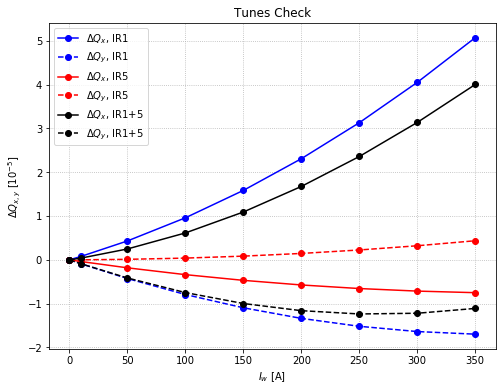

In [45]:
plt.figure(figsize=(8,6))
plt.plot(Iw, delta_qx_ir1*1e5,'-ob', label='$\\Delta Q_x$, IR1')
plt.plot(Iw, delta_qy_ir1*1e5,'--ob', label='$\\Delta Q_y$, IR1')

plt.plot(Iw, delta_qx_ir5*1e5,'-or', label='$\\Delta Q_x$, IR5')
plt.plot(Iw, delta_qy_ir5*1e5,'--or', label='$\\Delta Q_y$, IR5')

plt.plot(Iw, delta_qx_tot*1e5,'-ok', label='$\\Delta Q_x$, IR1+5')
plt.plot(Iw, delta_qy_tot*1e5,'--ok', label='$\\Delta Q_y$, IR1+5')

plt.legend(loc='best')
plt.grid(ls=':')
plt.xlabel('$I_w$ [A]')
plt.ylabel('$\\Delta Q_{x,y}$ [10$^{-5}$]')
plt.title('Tunes Check');

Since the effect on the tune is small, the effects of the two wires simply add up when powered together. The FF system guarantees to keep the tunes constant up to about 6$\cdot$10$^{-6}$ level.

#### Chromaticites

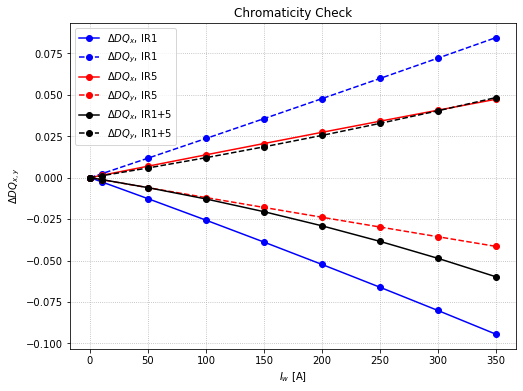

In [47]:
plt.figure(figsize=(8,6))
plt.plot(Iw, delta_dqx_ir1,'-ob', label='$\\Delta DQ_x$, IR1')
plt.plot(Iw, delta_dqy_ir1,'--ob', label='$\\Delta DQ_y$, IR1')

plt.plot(Iw, delta_dqx_ir5,'-or', label='$\\Delta DQ_x$, IR5')
plt.plot(Iw, delta_dqy_ir5,'--or', label='$\\Delta DQ_y$, IR5')

plt.plot(Iw, delta_dqx_tot,'-ok', label='$\\Delta DQ_x$, IR1+5')
plt.plot(Iw, delta_dqy_tot,'--ok', label='$\\Delta DQ_y$, IR1+5')

plt.legend(loc='best')
plt.grid(ls=':')
plt.xlabel('$I_w$ [A]')
plt.ylabel('$\\Delta DQ_{x,y}$')
plt.title('Chromaticity Check');

No problem with chromaticities.

#### Beta-beating

Considering the wires and their FF as a perturbation (confirmed by the previous checks of the tunes), $\beta$-beating is linear with the wire current. We can therefore study the $\beta$-beating only for the *worse* case scenario, ie, for maximum current in the wires. 

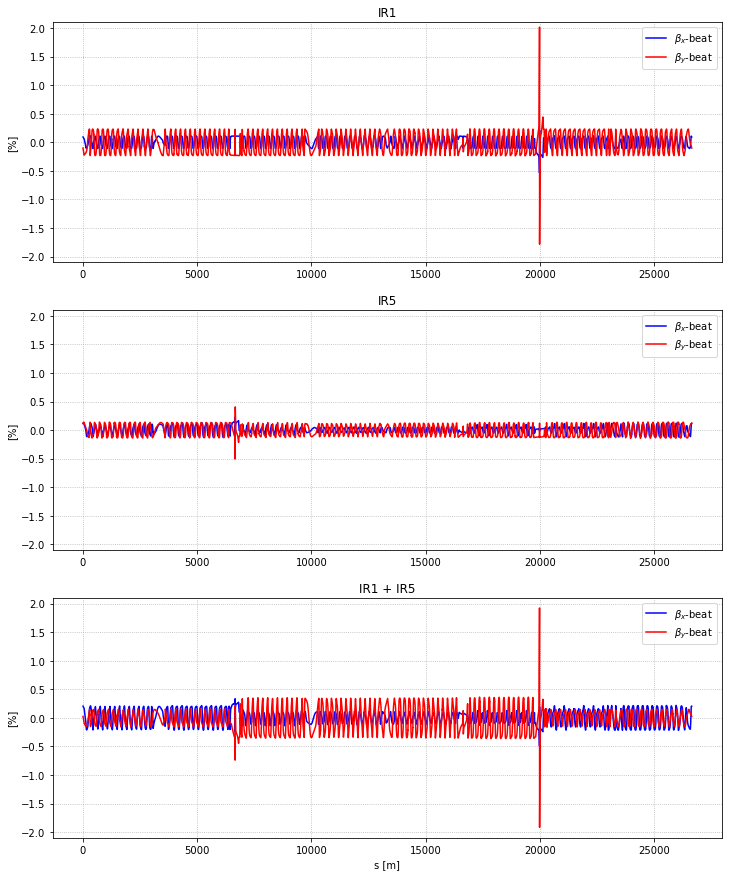

In [48]:
fig, axs = plt.subplots(3,figsize=(12,15))

s = mad.table.twiss['s']

axs[0].plot(s, betx_beat_ir1, 'b', label='$\\beta_x$-beat')
axs[0].plot(s, bety_beat_ir1, 'r', label='$\\beta_y$-beat')
axs[0].grid(ls=":")
axs[0].set_ylabel('[%]')
axs[0].set_title('IR1')
axs[0].legend(loc='best')
axs[0].set_ylim(-2.1,2.1)

axs[1].plot(s, betx_beat_ir5, 'b', label='$\\beta_x$-beat')
axs[1].plot(s, bety_beat_ir5, 'r', label='$\\beta_y$-beat')
axs[1].grid(ls=":")
axs[1].set_ylabel('[%]')
axs[1].set_title('IR5')
axs[1].legend(loc='best')
axs[1].set_ylim(-2.1,2.1)

axs[2].plot(s, betx_beat_tot, 'b', label='$\\beta_x$-beat')
axs[2].plot(s, bety_beat_tot, 'r', label='$\\beta_y$-beat')
axs[2].grid(ls=":")
axs[2].set_ylabel('[%]')
axs[2].set_xlabel('s [m]')
axs[2].legend(loc='best')
axs[2].set_ylim(-2.1,2.1)
axs[2].set_title('IR1 + IR5');

Beta-beating due to the wires seems under control, with a peak at 2% in the IR. To localize this peak, let us zoom around IP1. 

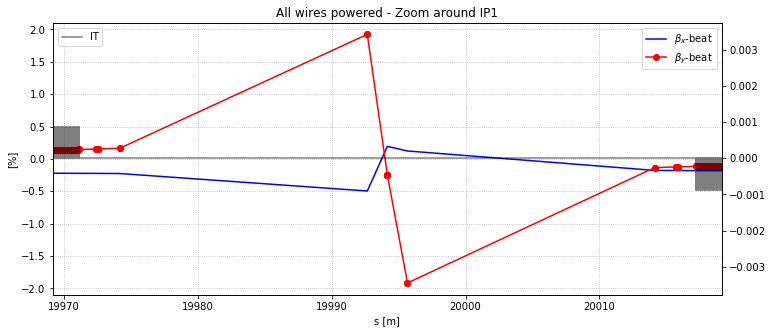

In [49]:
s_IP1 = tb.get_param_from_table(mad, 'twiss', 's', 'ip1:1')
s_lim = 25

fig, axs = plt.subplots(1,figsize=(12,5))

axs.plot(s, betx_beat_tot, 'b-', label='$\\beta_x$-beat')
axs.plot(s, bety_beat_tot, 'r-o', label='$\\beta_y$-beat')
axs.grid(ls=":")
axs.set_ylabel('[%]')
axs.set_xlabel('s [m]')
axs.legend(loc='best')
axs.set_ylim(-2.1,2.1)
axs.set_xlim(s_IP1-s_lim, s_IP1+s_lim)

ax2 = axs.twinx()
ax2.step(s, mad.table.twiss['k1l'], 'k', alpha=.5, label='IT')
ax2.legend(loc='upper left')
plt.title('All wires powered - Zoom around IP1');

The peak is localized in between the triplets, close to the IP, but not exactly at the IP. The BB elements are not installed in this example but previous checks allowed us to check that the peak is reached at the one of the extreme slice of the HO. 


The FF removes the linear part of the perturbation. As one can see on the tune checks, or simply by observing the residual $\beta$-beating, we are left with the non-linear part of it. But the FF is not intented to remove the $\beta$-beating that exists by construction due to the phasing between the Q4 and the wires. As one can see in the next cell, this $\beta$-beating is at the same level as the $\beta$-beating induced by a 0.01 Q-trim: 

In [97]:
mad.use(sequence='lhcb2')
for wire in wires_lst:
    wire.update_current(Iw_new=0)
mad.twiss(sequence='lhcb2')
qx_bef = mad.table.summ['q1'][0]
qy_bef = mad.table.summ['q2'][0]

betx_bef = mad.table.twiss['betx']
bety_bef = mad.table.twiss['bety']

qx_tar = qx_bef + 0.01
qy_tar = qy_bef - 0.01

mad.input(f'''
match;
global, q1={qx_tar}, q2={qy_tar};
vary,   name=dQx.b2_sq, step=1.0E-7 ;
vary,   name=dQy.b2_sq, step=1.0E-7 ;
lmdif,  calls=100, tolerance=1.0E-21;
endmatch; 
''')
mad.twiss(sequence='lhcb2')
qx_aft = mad.table.summ['q1'][0]
qy_aft = mad.table.summ['q2'][0]

betx_aft = mad.table.twiss['betx']
bety_aft = mad.table.twiss['bety']

betx_beat_qtrim = 100*(1-(betx_aft/betx_tot[0]))
bety_beat_qtrim = 100*(1-(bety_aft/bety_tot[0]))

(-2.1, 2.1)

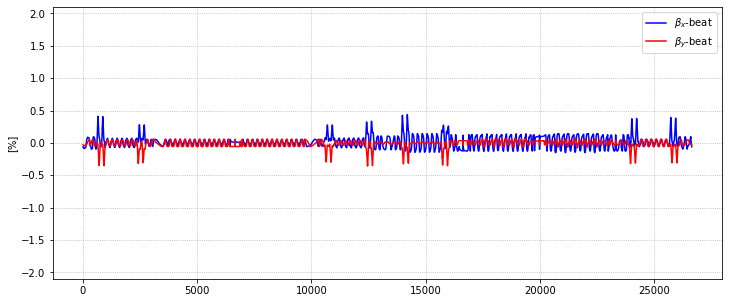

In [98]:
fig, axs = plt.subplots(1,figsize=(12,5))

s = mad.table.twiss['s']

axs.plot(s, betx_beat_qtrim, 'b', label='$\\beta_x$-beat')
axs.plot(s, bety_beat_qtrim, 'r', label='$\\beta_y$-beat')
axs.grid(ls=":")
axs.set_ylabel('[%]')
axs.legend(loc='best')
axs.set_ylim(-2.1,2.1)

#### **Orbit beating**

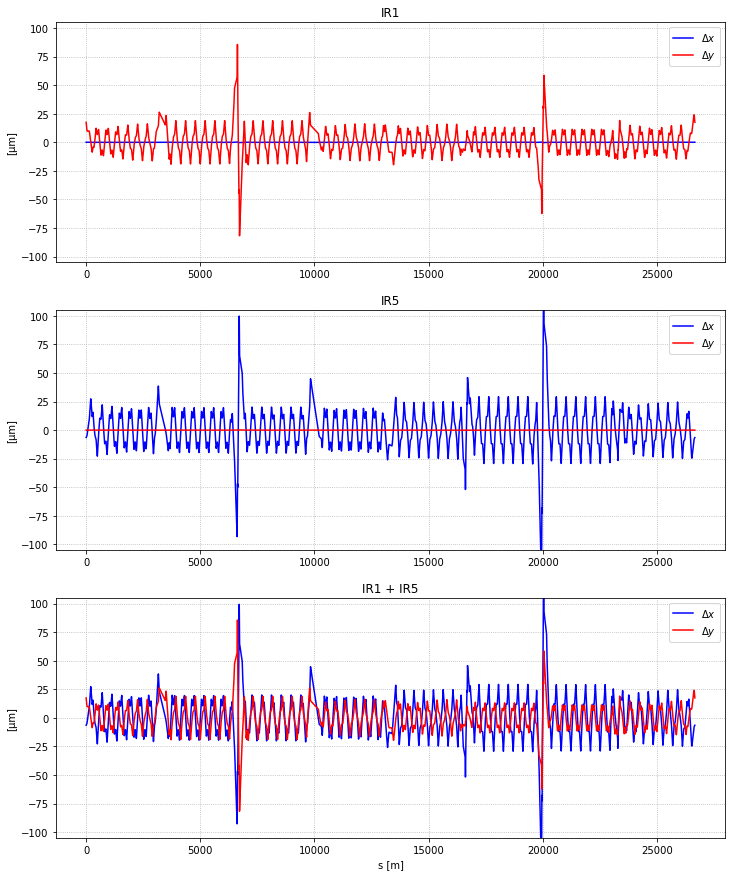

In [50]:
fig, axs = plt.subplots(3,figsize=(12,15))

s = mad.table.twiss['s']

axs[0].plot(s, (x_ir1[-1]-x_ir1[0])*1e6, 'b', label='$\\Delta x$')
axs[0].plot(s, (y_ir1[-1]-y_ir1[0])*1e6, 'r', label='$\\Delta y$')
axs[0].grid(ls=":")
axs[0].set_ylabel('[µm]')
axs[0].set_title('IR1')
axs[0].set_ylim(-105,105)
axs[0].legend(loc='best')

axs[1].plot(s, (x_ir5[-1]-x_ir5[0])*1e6, 'b', label='$\\Delta x$')
axs[1].plot(s, (y_ir5[-1]-y_ir5[0])*1e6, 'r', label='$\\Delta y$')
axs[1].grid(ls=":")
axs[1].set_ylabel('[µm]')
axs[1].set_title('IR5')
axs[1].set_ylim(-105,105)
axs[1].legend(loc='best')

axs[2].plot(s, (x_tot[-1]-x_tot[0])*1e6, 'b', label='$\\Delta x$')
axs[2].plot(s, (y_tot[-1]-y_tot[0])*1e6, 'r', label='$\\Delta y$')
axs[2].grid(ls=":")
axs[2].set_ylabel('[µm]')
axs[2].set_xlabel('s [m]')
axs[2].legend(loc='best')
axs[2].set_ylim(-105,105)
axs[2].set_title('IR1 + IR5');

The orbit shift induced by the FF (feed-down effect since the wires have no dipolar impact) stays under 100 µm, and should be cover by the orbit feedback. 

#### **Dispersion beating**

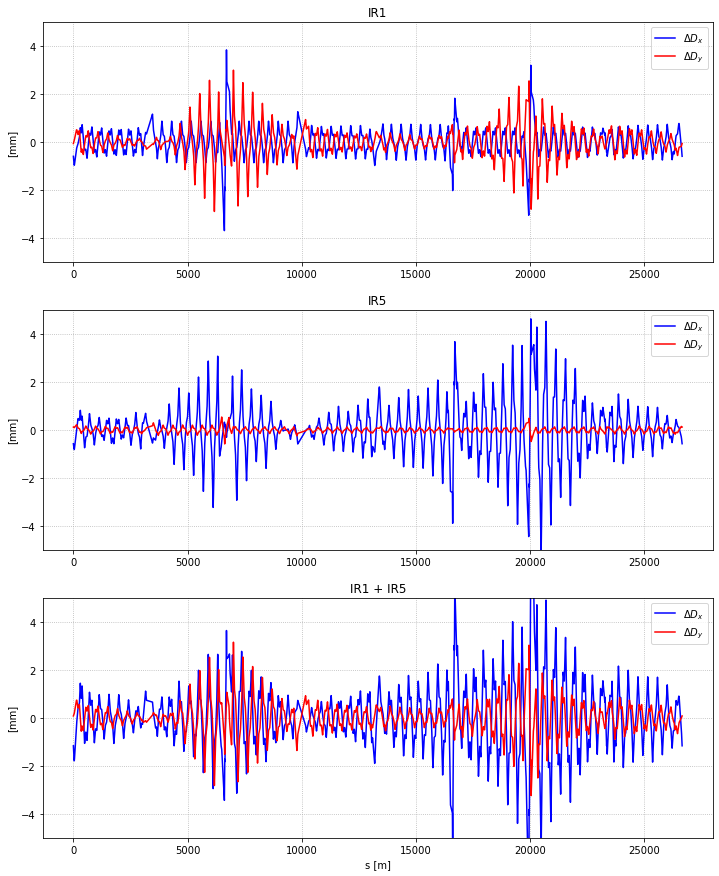

In [51]:
fig, axs = plt.subplots(3,figsize=(12,15))

s = mad.table.twiss['s']

axs[0].plot(s, (dx_ir1[-1]-dx_ir1[0])*1e3, 'b', label='$\\Delta D_x$')
axs[0].plot(s, (dy_ir1[-1]-dy_ir1[0])*1e3, 'r', label='$\\Delta D_y$')
axs[0].grid(ls=":")
axs[0].set_ylabel('[mm]')
axs[0].set_title('IR1')
axs[0].set_ylim(-5,5)
axs[0].legend(loc='best')

axs[1].plot(s, (dx_ir5[-1]-dx_ir5[0])*1e3, 'b', label='$\\Delta D_x$')
axs[1].plot(s, (dy_ir5[-1]-dy_ir5[0])*1e3, 'r', label='$\\Delta D_y$')
axs[1].grid(ls=":")
axs[1].set_ylabel('[mm]')
axs[1].set_title('IR5')
axs[1].set_ylim(-5,5)
axs[1].legend(loc='best')

axs[2].plot(s, (dx_tot[-1]-dx_tot[0])*1e3, 'b', label='$\\Delta D_x$')
axs[2].plot(s, (dy_tot[-1]-dy_tot[0])*1e3, 'r', label='$\\Delta D_y$')
axs[2].grid(ls=":")
axs[2].set_ylabel('[mm]')
axs[2].set_xlabel('s [m]')
axs[2].legend(loc='best')
axs[2].set_ylim(-5,5)
axs[2].set_title('IR1 + IR5');

Dispersion is under control, with variation up to the mm level.

### MKD/TCT phase advance

Finally we check the phase advance between the horizontal TCT in the high luminosity IPs and the MKD as a function of the wire current. First, let us check the initial value of this difference without wires:

In [52]:
print(f'Between TCTPH.4R1 and MKD : {divmod(mkd_tct1_mux[0],1)[1]*360} deg')
print(f'Between TCTPH.4R5 and MKD : {divmod(mkd_tct5_mux[0],1)[1]*360} deg')

Between TCTPH.4R1 and MKD : 209.05397569858275 deg
Between TCTPH.4R5 and MKD : 186.7520575256458 deg


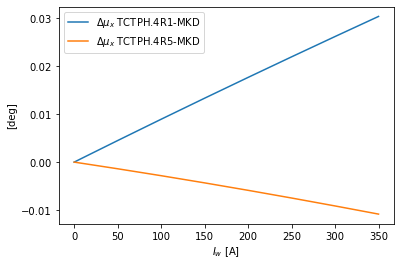

In [53]:
plt.plot(Iw, (mkd_tct1_mux - mkd_tct1_mux[0])*360, label='$\\Delta \\mu_x$ TCTPH.4R1-MKD')
plt.plot(Iw, (mkd_tct5_mux - mkd_tct5_mux[0])*360, label='$\\Delta \\mu_x$ TCTPH.4R5-MKD')
plt.ylabel('[deg]')
plt.xlabel('$I_w$ [A]')
plt.legend(loc='best');

The wires and their FF have no effect on the phase advance between the TCTPH and the MKD

## **Knob dependency on tele-index**

The last check to be done is the independency of the knobs on the tele-index. In the section, we compressed a bit the code, and scan the tele-index number, checking the tunes after the installation of the wires, at full current. 

!!! important
    This section is long to run, do not run it if not necessary. 

In [54]:
# Quadrupoles

q4_r1 = 'mqy.4r1.b2:1'
q4_l1 = 'mqy.4l1.b2:1'

q4_r5 = 'mqy.4r5.b2:1'
q4_l5 = 'mqy.4l5.b2:1'

# Wire

wire_r1 = 'bbcw_int_r1b2:1'
wire_r5 = 'bbcw_int_r5b2:1'

In [55]:
optics_nb = [21, 22, 23, 24, 25, 26, 27, 28]
qx_ats = []
qy_ats = []
dqx_ats = []
dqy_ats = []

pr_bet_y_q4r1 = []
pr_bet_y_q4l1 = []
pr_bet_y_wire_r1 = []

pr_bet_x_q4r5 = []
pr_bet_x_q4l5 = []
pr_bet_x_wire_r5 = []

betx_beat = []
bety_beat = []

mkd_tct1 = []
mkd_tct5 = []

    

for opt in optics_nb:
    for wire in wires_lst:
        wire.update_current(350)
        wire.switch_wire(on=False)
    
    parameter_dict.update({'par_optics_number':opt})
    
    workflow_dict['read_parameters_FT_FF'] = tb.read_parameters(mad, parameter_dict)
    workflow_dict['load_optics_FT_FF'] = tb.load_optics(mad, parameter_dict['par_optics_number'])
    workflow_dict['check_optics_FT_FF'] = tb.run_module(mad,'module_00_check_optics.madx')
    knob_dict={
        'on_sep1': 0,  
        'on_sep5': 0,         
        'on_sep2h': 1,
        'on_sep2v': 0,
        'on_x2h': 0,
        'on_x2v': 200,
        'on_sep8h': 0,
        'on_sep8v': 1,
        'on_x8h': 0,
        'on_x8v': 135,
        'on_disp': 1,
        'on_alice': 7000/parameter_dict['par_beam_energy_tot'],
        'on_lhcb': 7000/parameter_dict['par_beam_energy_tot'],
        'on_sol_atlas': 7000/parameter_dict['par_beam_energy_tot'],
        'on_sol_cms': 7000/parameter_dict['par_beam_energy_tot'],
        'on_sol_alice': 7000/parameter_dict['par_beam_energy_tot'],
    }
    betx_ip1 = mad.globals['betx_ip1']
    knob_dict['on_x1'] = tb.from_beta_to_xing_angle_urad(betx_ip1)
    knob_dict['on_x5'] = tb.from_beta_to_xing_angle_urad(betx_ip1)

    for i in knob_dict:
        mad.input(f'{i} = {knob_dict[i]};')
    workflow_dict['save_crossing_FT_FF'] = tb.run_module(mad,'module_01_save_crossing.madx')
    
    qx_0 = mad.table.summary_crossing_enable_b2['q1'][0]
    qy_0 = mad.table.summary_crossing_enable_b2['q2'][0]
    
    dqx_0 = mad.table.summary_crossing_enable_b2['dq1'][0]
    dqy_0 = mad.table.summary_crossing_enable_b2['dq2'][0]
    
    betx_0 = mad.table.twiss_crossing_enable_b2['betx']
    bety_0 = mad.table.twiss_crossing_enable_b2['bety']
    
    # scalability
    table = 'twiss_crossing_enable_b2'
    pr_bet_y_q4r1.append(betx_ip1*tb.get_param_from_table(mad, table, 'bety', q4_r1))
    pr_bet_y_q4l1.append(betx_ip1*tb.get_param_from_table(mad, table, 'bety', q4_l1))
    pr_bet_y_wire_r1.append(betx_ip1*tb.get_param_from_table(mad, table, 'bety', wire_r1))
    
    pr_bet_x_q4r5.append(betx_ip1*tb.get_param_from_table(mad, table, 'betx', q4_r5))
    pr_bet_x_q4l5.append(betx_ip1*tb.get_param_from_table(mad, table, 'betx', q4_l5))
    pr_bet_x_wire_r5.append(betx_ip1*tb.get_param_from_table(mad, table, 'betx', wire_r5))
    
    # Define the knobs for wire matching
    knobs_run3 = KnobObj(mad_inst=mad)
    knobs_run3.define_q4_ir1_knob_b2(wire_ir1=bbcw_int_r1b2)
    knobs_run3.define_q4_ir5_knob_b2(wire_ir5=bbcw_int_r5b2)
    
    # Update wire position
    for wire in wires_lst:
        wire.get_closed_orbit(table_input='twiss_crossing_enable_b2')

    workflow_dict['turn_on_wires'] = tb.power_wires(wires_lst,table_out='b2_wires')
    
    betx = mad.table.twiss_b2_wires['betx']
    bety = mad.table.twiss_b2_wires['bety']
    
    betx_beat.append(np.max(100*(1-(betx/betx_0))))
    bety_beat.append(np.max(100*(1-(bety/bety_0))))
    
    mkd_tct1.append(tb.get_param_from_table(mad,table='twiss_b2_wires',param='mux',element=tct_ir1) - tb.get_param_from_table(mad,table='twiss_b2_wires',param='mux',element=mkd))
    mkd_tct5.append(tb.get_param_from_table(mad,table='twiss_b2_wires',param='mux',element=tct_ir5)-(tb.get_param_from_table(mad,table='twiss_b2_wires',param='mux',element='ip3:1')) + \
            tb.get_param_from_table(mad,table='twiss_b2_wires',param='mux',element='lhcb2ip3_p_:1')-(tb.get_param_from_table(mad,table='twiss_b2_wires',param='mux',element=mkd)))
    
    
    qx_ats.append(mad.table.summary_b2_wires['q1']-qx_0)
    qy_ats.append(mad.table.summary_b2_wires['q2']-qy_0)
    dqx_ats.append(mad.table.summary_b2_wires['dq1']-dqx_0)
    dqy_ats.append(mad.table.summary_b2_wires['dq2']-dqy_0)
    
    gc.collect()
    


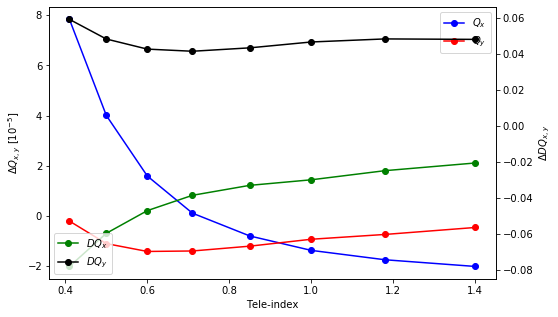

In [56]:
tele_index = [1.4, 1.18, 1, 0.85, 0.71, 0.6, 0.5, 0.41]

fig, axs = plt.subplots(1,figsize=(8,5))

axs.plot(tele_index, np.array(qx_ats)*1e5, 'bo-', label='$Q_x$')
axs.plot(tele_index, np.array(qy_ats)*1e5, 'ro-', label='$Q_y$')
axs.set_ylabel('$\\Delta Q_{x,y}$ [10$^{-5}$]')
axs.set_xlabel('Tele-index')
axs.legend(loc='upper right')


ax1 = axs.twinx()
ax1.plot(tele_index, dqx_ats, 'go-', label='$DQ_x$')
ax1.plot(tele_index, dqy_ats, 'ko-', label='$DQ_y$')
ax1.set_ylabel('$\\Delta DQ_{x,y}$')
ax1.legend(loc='lower left');

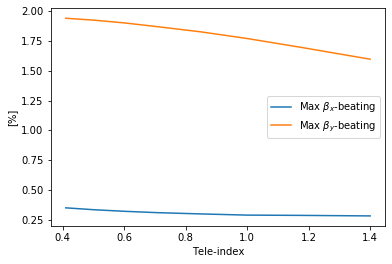

In [57]:
plt.plot(tele_index, betx_beat, label='Max $\\beta_x$-beating')
plt.plot(tele_index, bety_beat, label='Max $\\beta_y$-beating')
plt.ylabel('[%]')
plt.legend(loc='best')
plt.xlabel('Tele-index');

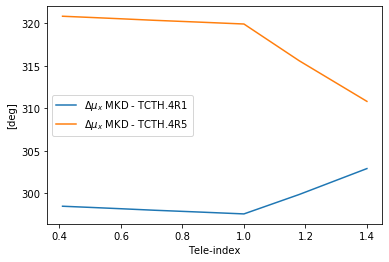

In [58]:
plt.plot(tele_index, divmod(np.array(mkd_tct1),1)[1]*360, label='$\\Delta \\mu_x$ MKD - TCTH.4R1')
plt.plot(tele_index, divmod(np.array(mkd_tct5),1)[1]*360, label='$\\Delta \\mu_x$ MKD - TCTH.4R5')
plt.ylabel('[deg]')
plt.legend(loc='best')
plt.xlabel('Tele-index');

The FF system is almost ATS independant if one accepts a tune variation of around 10$^{-5}$. The $\beta$-beating is not affected by the change of tele-index and the phase advance between the horizontal TCTs and the MKD remains within the tolerances. 

In [52]:
elasped_time = time.time() - start_time  
print(str(datetime.timedelta(seconds=elasped_time))[:-3])

0:09:48.979


---
## **Conclusions** 

- During the tests at injection and flat-top energies, in open loop (no feed-forward), we saw that the orbit and tune shift due to a single wire were correctly predicted by the analytical formula. 

- A tune feed-forward system has been implemented to compensated the wire induced tune shift in operation. This knob uses the Q4 quadrupoles in IR1 and IR5. 

- Once the wires powered, and their FF active, no significant effect is observed in the machine in terms of linear optics.

- Finally we saw that the developped knob is ATS independant. It can therefore be used for different values of beta-star (even if not foreseen for the operation on LHC during Run 3). 